# 搭建CNN

In [18]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten , Dense ,Dropout
from keras import backend as K
from imutils import paths
from keras import applications
from keras.layers import Input, concatenate, GlobalAveragePooling2D
from keras.models import Model,load_model
from keras import regularizers
from keras.applications import ResNet50
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="1"  

base_model = ResNet50(input_shape=(512,512,3),include_top=False, weights='imagenet')


# # build a classifier model to put on top of the convolutional model
# top_model = Sequential()

# top_model.add(AveragePooling2D(input_shape=base_model.output_shape[1:]))
# # top_model.add(AveragePooling2D())
# top_model.add(Dense(512, activation='relu'))
# top_model.add(Dropout(0.5))
# top_model.add(Dense(12, activation='softmax'))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512,activation='relu')(x)
x = Dropout(0.5)(x)
prediction = Dense(12,activation='softmax')(x)
        
model = Model(inputs=base_model.input, outputs=prediction) 

# 声明全局变量

In [19]:
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import sys
sys.path.append('..')


# initialize the number of epochs to train for, initial learning rate,
# and batch size
EPOCHS = 50
INIT_LR = 1e-3
BS = 5
CLASS_NUM = 12
norm_size = 512



# 导入数据

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_data(path):
    print('[INFO] loading images...')
    data = []
    labels = []
    # grad the image paths and randomly shuffle them
    imagePaths = sorted(list(paths.list_images(path)))
#     print(imagePaths)
    random.seed(42)
    random.shuffle(imagePaths)
    # loop over the imput image 
    for imagePath in imagePaths:
        image = cv2.imread(imagePath)
#         print(image)
        image = cv2.resize(image, (norm_size,norm_size))
        image = img_to_array(image)
        data.append(image)
        
        # extract the class label from the image path and update the label list
        label = str(imagePath.split(os.path.sep)[-2])
#         print(label)
        labels.append(label)
        
    # scale the raw pixel intensities to the range(0,1)
    data = np.array(data,dtype="float") / 255.0
    labels = np.array(labels)
    
    labels = to_categorical(labels,num_classes=CLASS_NUM)
    return data,labels

def panda_data(label):
    number_list = label
    num_list = ['norm','defect1','defect2','defect3','defect4','defect5','defect6','defect7','defect8','defect9','defect10','defect11']
    plt.figure(figsize=(20,10))
    plt.bar(range(len(number_list)), number_list, tick_label = num_list)
    plt.show()
#     df = pd.DataFrame(
#     {'Number' : label}, 
#         index = ['norm','defect1','defect2','defect3','defect4','defect5','defect6','defect7','defect8','defect9','defect10','defect11'])
#     df.hist(grid=False,column="Number")


[INFO] loading images...


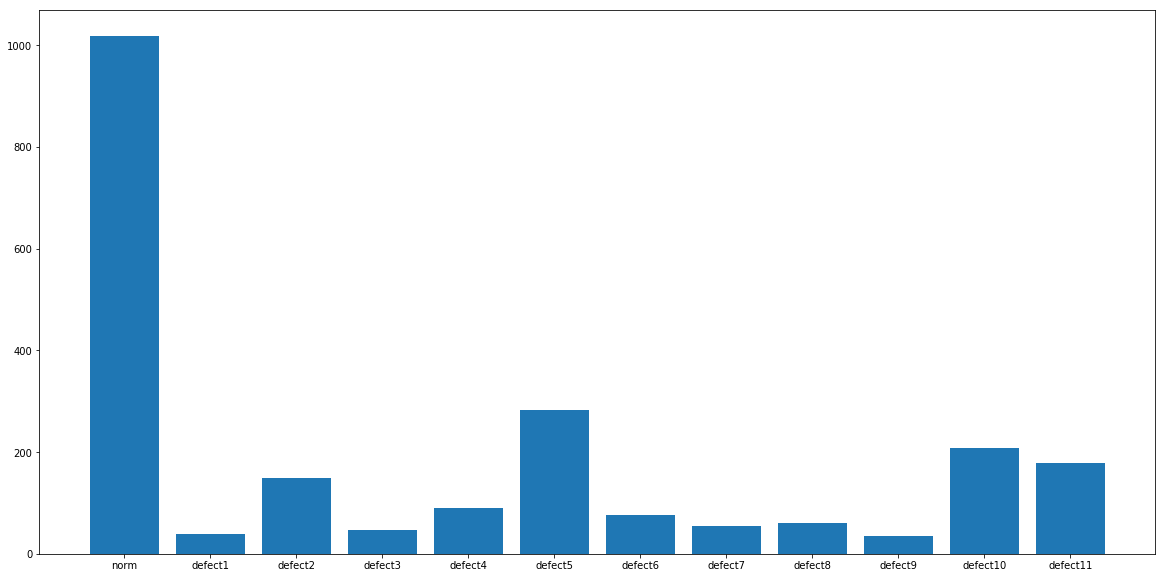

[1018.0, 39.0, 149.0, 47.0, 90.0, 282.0, 77.0, 54.0, 61.0, 35.0, 209.0, 178.0]


In [5]:
from imutils import paths
import random
import cv2

train_file_path = "/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data"
trainX,trainY = load_data(train_file_path)
col = map(sum,zip(*trainY))   #按列相加
panda_data(col)
print(col)

# 自定义评价函数

In [21]:
import tensorflow as tf
def metric_LB(y_true,y_pred):
    y_pred_label = K.argmax(y_pred,axis=-1)
    y_pred_ = K.one_hot(y_pred_label,num_classes=12)
    tp_fp = K.sum(y_pred_,axis=0)
    n = tf.count_nonzero(tp_fp,dtype='float32')
    tp = K.sum(y_true*y_pred_,axis=0)
    return K.sum(tp/(tp_fp+1e-6))/n

# 训练数据

In [22]:
from keras.callbacks import ReduceLROnPlateau

# 当评价指标不在提升时，减少学习率
reduce_lr = ReduceLROnPlateau(monitor='val_metric_LB', patience=5, mode='auto',factor=0.5,min_lr =0.5e-6)

def train(aug,trainX,trainY,testX,testY):
    # initialize the model
    print("[INFO] compiling model ...")

    model.compile(loss=focal_loss_fixed,
              optimizer=optimizers.Adam(lr=1e-4, decay=1e-6),
              metrics=['accuracy', metric_LB])
    #train the network
    print("[INFO] training network...")
    H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),
        validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,
        epochs=EPOCHS, verbose=1,callbacks=[checkpoint,reduce_lr],class_weight={0:1., 1:26.25806452, 2:6.832214, 3:21.42105263, 
                                                                                                                  4:11.30555556, 5:3.609929078, 6:13.12903226, 
                                                                                                                  7:18.85023256, 8:16.41917647, 9:29.07142857,
                                                                                                                  10:4.8742515 ,  11:5.7197011234 
                                                                                                                    })

    # save the model to disk
    print("[INFO] serializing network...")
    
    # plot the training loss and accuracy
    plt.style.use("ggplot")
    plt.figure()
    N = EPOCHS
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
    plt.title("Training Loss and Accuracy on rolled_steel classifier")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig("/home/weijia.wu/workspace/Kaggle/rolled_steel/Net_Gangecai/result/ResNet_weijiawu_20.png")

# Focal loss keras

In [23]:
gamma=2.
alpha=.25
def focal_loss_fixed(y_true, y_pred):
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

# 实时优化器

In [24]:
from keras.callbacks import ModelCheckpoint
filepath = '/home/weijia.wu/workspace/Kaggle/rolled_steel/Net_Gangecai/result/ResNet_weijiawu_20.model'
checkpoint = ModelCheckpoint(
    filepath, 
    monitor='val_metric_LB', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False, 
    mode='max', 
    period=1
)

# 导入数据并开始训练

In [36]:
model.load_weights("/home/weijia.wu/workspace/Kaggle/rolled_steel/Net_Gangecai/result/ResNet_weijiawu_12.model")

In [37]:
import os
from keras import optimizers
from sklearn.model_selection import train_test_split
 

if __name__=='__main__':
    train_file_path = "/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/train_data"
    trainX,trainY = load_data(train_file_path)
    trainX,testX,trainY,testY= train_test_split(trainX,trainY,test_size=0.2,random_state=0)
#     construct the image generator for data augmentation
    aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
        height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
        horizontal_flip=True, fill_mode="nearest")
    train(aug,trainX,trainY,testX,testY)

[INFO] loading images...


KeyboardInterrupt: 

# 预测数据集

In [38]:
import os
import cv2
path = "/home/weijia.wu/workspace/Kaggle/rolled_steel/dataset/guangdong_round1_test_b_20181009/"
# model = load_model("/home/weijia.wu/workspace/Kaggle/rolled_steel/LeNet_Gangecai/traffic_sign.model")

#!/usr/bin/env python
# coding=utf-8
 
from xlwt import *
#需要xlwt库的支持
#import xlwt
file = Workbook(encoding = 'utf-8')
#指定file以utf-8的格式打开
table = file.add_sheet('data')
#指定打开的文件名
ImageId = []
Label = []
def test(args):
    image = cv2.imread(args)
    orig = image.copy()
    # pre-process the image for classification
    image = cv2.resize(image, (norm_size, norm_size))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
     
    # classify the input image
    result = model.predict(image)[0]
    proba = np.max(result)
    label = int(np.where(result==proba)[0])
    return label

files = os.listdir(path)

for i in files:
    result = test(path + i)
    ImageId.append(i)
    if result == 0:
        defa = 'norm'
    else:
        defa = 'defect' + str(result)
    Label.append(defa)
#     print(i , result)
#     print(defa)
          
print(ImageId)
print(Label)


['486.jpg', '81.jpg', '617.jpg', '661.jpg', '132.jpg', '652.jpg', '289.jpg', '166.jpg', '853.jpg', '466.jpg', '997.jpg', '916.jpg', '895.jpg', '199.jpg', '810.jpg', '737.jpg', '3.jpg', '953.jpg', '504.jpg', '520.jpg', '982.jpg', '531.jpg', '573.jpg', '775.jpg', '154.jpg', '930.jpg', '76.jpg', '373.jpg', '616.jpg', '185.jpg', '139.jpg', '14.jpg', '963.jpg', '116.jpg', '872.jpg', '643.jpg', '236.jpg', '968.jpg', '16.jpg', '265.jpg', '69.jpg', '693.jpg', '181.jpg', '729.jpg', '751.jpg', '391.jpg', '151.jpg', '380.jpg', '164.jpg', '368.jpg', '68.jpg', '461.jpg', '301.jpg', '819.jpg', '600.jpg', '410.jpg', '204.jpg', '567.jpg', '381.jpg', '386.jpg', '666.jpg', '970.jpg', '388.jpg', '658.jpg', '932.jpg', '462.jpg', '630.jpg', '623.jpg', '683.jpg', '954.jpg', '29.jpg', '438.jpg', '309.jpg', '228.jpg', '351.jpg', '902.jpg', '892.jpg', '34.jpg', '550.jpg', '0.jpg', '294.jpg', '766.jpg', '647.jpg', '311.jpg', '307.jpg', '684.jpg', '778.jpg', '536.jpg', '74.jpg', '45.jpg', '100.jpg', '558.jpg', '

In [40]:
import pandas as pd
submissions=pd.DataFrame({"ImageId": ImageId,
                         "Label": Label})
submissions.to_csv("DRresult1.csv", index=False, header=None)